Step 0/7068 completed
Step 100/7068 completed
Step 200/7068 completed
Step 300/7068 completed
Step 400/7068 completed
Step 500/7068 completed
Step 600/7068 completed
Step 700/7068 completed
Step 800/7068 completed
Step 900/7068 completed
Step 1000/7068 completed
Step 1100/7068 completed
Step 1200/7068 completed
Step 1300/7068 completed
Step 1400/7068 completed
Step 1500/7068 completed
Step 1600/7068 completed
Step 1700/7068 completed
Step 1800/7068 completed
Step 1900/7068 completed
Step 2000/7068 completed
Step 2100/7068 completed
Step 2200/7068 completed
Step 2300/7068 completed
Step 2400/7068 completed
Step 2500/7068 completed
Step 2600/7068 completed
Step 2700/7068 completed
Step 2800/7068 completed
Step 2900/7068 completed
Step 3000/7068 completed
Step 3100/7068 completed
Step 3200/7068 completed
Step 3300/7068 completed
Step 3400/7068 completed
Step 3500/7068 completed
Step 3600/7068 completed
Step 3700/7068 completed
Step 3800/7068 completed
Step 3900/7068 completed
Step 4000/70

TypeError: Invalid shape (213,) for image data

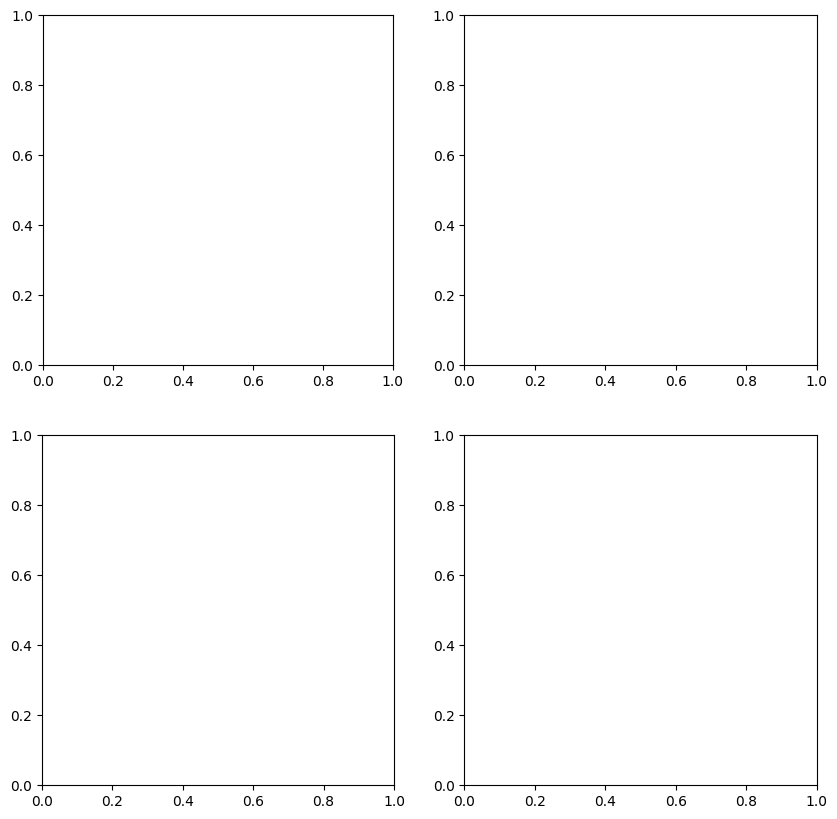

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import h, hbar, mu_0, c, elementary_charge as e, k as kB
from scipy import stats
from scipy.optimize import curve_fit

# Constants for ^88Sr 5s^2 ^1S_0 → 5s5p ^3P_1 transition
m = 87.62 * 1.66e-27  # mass of Sr-88 in kg
g = 9.81  # acceleration due to gravity in m/s^2
gamma = 2 * np.pi * 7.5e3  # natural linewidth
lambda_light = 689e-9  # wavelength of light in m
k = 2 * np.pi / lambda_light  # wavevector
gamma_B = 0.08  # magnetic field gradient in T/m
mu_B = 9.274e-24  # Bohr magneton
g_factor = 1.5  # Landé g-factor for 3P1 state

# Simulation parameters
N_atoms = 100  # number of atoms
dt = 0.1 / gamma  # time step
t_total = 15e-3  # total simulation time
steps = int(t_total / dt)

# Define laser beam directions and polarizations
beam_directions = np.array([[1,0,0], [-1,0,0], [0,1,0], [0,-1,0], [0,0,1], [0,0,-1]])
beam_polarizations = np.array([
    [0, 1, -1j],  [0, 1, 1j],   # σ- for +x, σ+ for -x
    [1, 0, -1j],  [1, 0, 1j],   # σ- for +y, σ+ for -y
    [-1, -1j, 0], [-1, 1j, 0]   # σ- for +z, σ+ for -z
]) / np.sqrt(2)

def initialize_atoms(N, initial_temp, ellipsoid_radii):
    # Create positions in a user-defined ellipsoid
    u = np.random.random(N)
    v = np.random.random(N)
    w = np.random.random(N)
    
    theta = 2 * np.pi * u
    phi = np.arccos(2 * v - 1)
    r = np.cbrt(w)
    
    x = ellipsoid_radii[0] * r * np.sin(phi) * np.cos(theta)
    y = ellipsoid_radii[1] * r * np.sin(phi) * np.sin(theta)
    z = ellipsoid_radii[2] * r * np.cos(phi)
    
    positions = np.column_stack((x, y, z))
    
    # Create velocities from 3D-Boltzmann distribution
    velocities = np.random.normal(0, np.sqrt(kB * initial_temp / m), (N, 3))
    
    # Initialize all atoms in ground state (J=0, mj=0)
    states = np.zeros(N, dtype=int)
    
    return positions, velocities, states

def quadrupole_field(pos):
    """
    Calculate the quadrupole magnetic field B = γ × (x𝑥̂ + y𝑦̂ - 2z𝑧̂)
    """
    return gamma_B * np.array([pos[..., 0], pos[..., 1], -2*pos[..., 2]])


def create_absorption_image(positions, bin_size=1e-5):
    x_bins = np.arange(positions[:, 0].min(), positions[:, 0].max() + bin_size, bin_size)
    z_bins = np.arange(positions[:, 2].min(), positions[:, 2].max() + bin_size, bin_size)
    
    hist, _, _ = np.histogram2d(positions[:, 0], positions[:, 2], bins=(x_bins, z_bins))
    column_density = np.sum(hist, axis=1)  # Sum along y-axis
    
    return column_density / np.max(column_density)  # Normalize

def create_force_curve(z_range, Delta, S):
    z = np.linspace(z_range[0], z_range[1], 1000)
    positions = np.array([np.zeros_like(z), np.zeros_like(z), z]).T
    velocities = np.zeros_like(positions)
    
    total_force = np.zeros_like(z)
    for beam_direction, beam_polarization in zip(beam_directions, beam_polarizations):
        for mj in [-1, 0, 1]:
            rate = scattering_rate(positions, velocities, k * beam_direction, beam_polarization, Delta, S, mj)
            force = rate * hbar * k * beam_direction[2]  # Only z component
            total_force += force
    
    return z, total_force - m * g  # Subtract gravitational force


def maxwell_boltzmann(v, A, T):
    return A * v**2 * np.exp(-m * v**2 / (2 * kB * T))

def calculate_temperature(velocities):
    v_x = velocities[:, 0]
    v_z = velocities[:, 2]
    
    v_x_abs = np.abs(v_x)
    v_z_abs = np.abs(v_z)
    
    bins_x = np.linspace(0, np.max(v_x_abs), 50)
    bins_z = np.linspace(0, np.max(v_z_abs), 50)
    
    hist_x, bin_edges_x = np.histogram(v_x_abs, bins=bins_x, density=True)
    hist_z, bin_edges_z = np.histogram(v_z_abs, bins=bins_z, density=True)
    
    bin_centers_x = (bin_edges_x[:-1] + bin_edges_x[1:]) / 2
    bin_centers_z = (bin_edges_z[:-1] + bin_edges_z[1:]) / 2
    
    popt_x, _ = curve_fit(maxwell_boltzmann, bin_centers_x, hist_x, p0=[1, 1e-6])
    popt_z, _ = curve_fit(maxwell_boltzmann, bin_centers_z, hist_z, p0=[1, 1e-6])
    
    T_x = popt_x[1]
    T_z = popt_z[1]
    
    return T_x, T_z

def calculate_coupling_strengths(B_field, laser_polarization):
    """
    Calculate the coupling strengths Wj based on the local magnetic field
    and the polarization of the nMOT laser beam.
    """
    # Convert laser polarization from Cartesian to spherical basis
    E_spherical = cartesian_to_spherical(laser_polarization)
    
    # Check if we're dealing with a single atom or an array of atoms
    single_atom = B_field.ndim == 1
    
    if single_atom:
        B_field = B_field.reshape(3, 1)
    
    # Calculate rotation angles
    B_unit = B_field / np.linalg.norm(B_field, axis=0)
    theta = np.arccos(B_unit[2])
    phi = np.arctan2(B_unit[1], B_unit[0])
    
    # Construct rotation matrix Mq(θ)
    M_q = construct_rotation_matrix(theta)
    
    # Rotate polarization to local atomic frame
    if single_atom:
        E_prime = M_q @ E_spherical
    else:
        E_prime = np.einsum('ijk,k->ij', M_q, E_spherical)
    
    # Calculate coupling strengths
    W = np.abs(E_prime)**2
    
    return W.squeeze()


def cartesian_to_spherical(E_cartesian):
    """
    Convert electric field from Cartesian to spherical basis.
    """
    E_x, E_y, E_z = E_cartesian
    E_spherical = np.array([
        -1/np.sqrt(2) * (E_x + 1j*E_y),  # E^1
        E_z,                             # E^0
        1/np.sqrt(2) * (E_x - 1j*E_y)    # E^-1
    ])
    return E_spherical

def construct_rotation_matrix(theta):
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    M_q = 0.5 * np.array([
        [1 + cos_theta, -np.sqrt(2)*sin_theta, 1 - cos_theta],
        [np.sqrt(2)*sin_theta, 2*cos_theta, -np.sqrt(2)*sin_theta],
        [1 - cos_theta, np.sqrt(2)*sin_theta, 1 + cos_theta]
    ])
    if theta.ndim == 0:
        return M_q
    else:
        return np.moveaxis(M_q, [0, 1], [-2, -1])



def zeeman_splitting(B):
    """
    Calculate the Zeeman splitting Δωz = gμB|B|/ℏ
    """
    return g_factor * mu_B * np.linalg.norm(B, axis=0) / hbar

def detuning(pos, vel, laser_k, Delta, mj):
    B = quadrupole_field(pos)
    delta_z = zeeman_splitting(B) * mj
    return Delta - np.dot(laser_k, vel.T).T - delta_z


def check_resonance_condition(pos, vel, laser_k, Delta, mj):
    return np.abs(detuning(pos, vel, laser_k, Delta, mj)) < gamma

def check_zeeman_condition(pos):
    B = quadrupole_field(pos)
    B_mag = np.linalg.norm(B)
    zeeman_splitting = mu_B * g_factor * B_mag / hbar
    return zeeman_splitting > 10 * gamma  # Zeeman splitting much greater than linewidth

def scattering_rate(pos, vel, laser_k, laser_pol, Delta, S, mj):
    delta = detuning(pos, vel, laser_k, Delta, mj)
    B = quadrupole_field(pos)
    W = calculate_coupling_strengths(B, laser_pol)
    if W.ndim == 1:
        W = W[mj+1]  # +1 because mj goes from -1 to 1
    else:
        W = W[:, mj+1]
    return (gamma / 2) * (W * S / (1 + W * S + 4 * (delta / gamma)**2))

def determine_regime(S, Delta):
    if S > 1 and np.abs(Delta) < gamma * np.sqrt(1 + S):
        return "I"  # Doppler regime
    elif S > 1 and np.abs(Delta) > gamma * np.sqrt(1 + S):
        return "II"  # Power-broadened regime
    else:
        return "III"  # Quantum regime

def run_simulation(positions, velocities, states, Delta, S):
    trajectories = np.zeros((steps, N_atoms, 3))
    velocity_histories = np.zeros((steps, N_atoms, 3))

    regime = determine_regime(S, Delta)
    for step in range(steps):
        # Inside the time step loop:
        trajectories[step] = positions
        velocity_histories[step] = velocities

        
        for i in range(N_atoms):
            if not check_zeeman_condition(positions[i]):
                continue  # Skip this atom if Zeeman condition is not met

            # Calculate scattering rates for each beam and each mj state
            rates = [[scattering_rate(positions[i], velocities[i], k * beam_directions[j],
                                      beam_polarizations[j], Delta, S, mj)
                      for mj in [-1, 0, 1]]
                     for j in range(6)]
            total_rate = sum(sum(beam_rates) for beam_rates in rates)
        
            
            # Determine if a scattering event occurs
            scattering_event = np.random.random() < total_rate * dt

            if scattering_event:
                # Choose which beam and mj state caused the absorption
                flat_rates = [rate for beam_rates in rates for rate in beam_rates]
                choice = np.random.choice(18, p=np.array(flat_rates)/total_rate)
                beam_index, mj = divmod(choice, 3)
                mj -= 1  # Convert back to -1, 0, 1
                
                # Check resonance condition
                if check_resonance_condition(positions[i], velocities[i], k * beam_directions[beam_index], Delta, mj):
                    # Calculate momentum kicks
                    k_i = k * beam_directions[beam_index]
                    phi = np.random.uniform(0, 2*np.pi)
                    theta = np.arccos(1 - 2*np.random.random())
                    k_s = k * np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
                    
                    # Update velocity with absorption, emission, and gravity
                    velocities[i] += (hbar / m) * (k_i + k_s) + np.array([0, 0, -g]) * dt
                    
                    # Update atomic state
                    states[i] = mj + 1  # Store as 0, 1, 2 for simplicity
                    
                    # Reset to ground state after emission
                    states[i] = 0
            else:
                # Update velocity and position without scattering
                velocities[i] += np.array([0, 0, -g]) * dt
                positions[i] += velocities[i] * dt + 0.5 * np.array([0, 0, -g]) * dt**2

            # Update position for scattering case
            if scattering_event:
                positions[i] += velocities[i] * dt
        
        if step % 100 == 0:
            print(f"Step {step}/{steps} completed. Current regime: {regime}")


    return positions, velocities, states

def run_simulation_step(positions, velocities, states, Delta, S):
    for i in range(N_atoms):
        if not check_zeeman_condition(positions[i]):
            continue  # Skip this atom if Zeeman condition is not met

        # Calculate scattering rates for each beam and each mj state
        rates = [[scattering_rate(positions[i], velocities[i], k * beam_directions[j],
                                  beam_polarizations[j], Delta, S, mj)
                  for mj in [-1, 0, 1]]
                 for j in range(6)]
        total_rate = sum(sum(beam_rates) for beam_rates in rates)
    
        # Determine if a scattering event occurs
        scattering_event = np.random.random() < total_rate * dt

        if scattering_event:
            # Choose which beam and mj state caused the absorption
            flat_rates = [rate for beam_rates in rates for rate in beam_rates]
            choice = np.random.choice(18, p=np.array(flat_rates)/total_rate)
            beam_index, mj = divmod(choice, 3)
            mj -= 1  # Convert back to -1, 0, 1
            
            # Check resonance condition
            if check_resonance_condition(positions[i], velocities[i], k * beam_directions[beam_index], Delta, mj):
                # Calculate momentum kicks
                k_i = k * beam_directions[beam_index]
                phi = np.random.uniform(0, 2*np.pi)
                theta = np.arccos(1 - 2*np.random.random())
                k_s = k * np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
                
                # Update velocity with absorption, emission, and gravity
                velocities[i] += (hbar / m) * (k_i + k_s) + np.array([0, 0, -g]) * dt
                
                # Update atomic state
                states[i] = mj + 1  # Store as 0, 1, 2 for simplicity
                
                # Reset to ground state after emission
                states[i] = 0
        else:
            # Update velocity and position without scattering
            velocities[i] += np.array([0, 0, -g]) * dt

        # Update position
        positions[i] += velocities[i] * dt + 0.5 * np.array([0, 0, -g]) * dt**2

    return positions, velocities, states

def run_simulation_for_image(Delta, S, simulation_time):
    positions, velocities, states = initialize_atoms(N_atoms, initial_temp, ellipsoid_radii)
    steps = int(simulation_time / dt)
    
    for step in range(steps):
        positions, velocities, states = run_simulation_step(positions, velocities, states, Delta, S)
        if step % 100 == 0:
            print(f"Step {step}/{steps} completed")

    
    return positions

def plot_figure_1():
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    
    # Scenario 1: S = 250, Delta = -2π × 110 kHz
    S1, Delta1 = 250, -2 * np.pi * 110e3
    positions1 = run_simulation_for_image(Delta1, S1, 15e-3)
    image1 = create_absorption_image(positions1)
    z1, force1 = create_force_curve((-200e-6, 200e-6), Delta1, S1)
    
    # Scenario 2: S = 20, Delta = -2π × 200 kHz
    S2, Delta2 = 20, -2 * np.pi * 200e3
    positions2 = run_simulation_for_image(Delta2, S2, 15e-3)
    image2 = create_absorption_image(positions2)
    z2, force2 = create_force_curve((-200e-6, 200e-6), Delta2, S2)
    
    # Plot absorption images
    axs[0, 0].imshow(image1, extent=[-200, 200, -200, 200], aspect='equal', cmap='Blues')
    axs[1, 0].imshow(image2, extent=[-200, 200, -200, 200], aspect='equal', cmap='Blues')
    
    # Plot force curves
    axs[0, 1].plot(z1 * 1e6, force1 * 1e23)
    axs[1, 1].plot(z2 * 1e6, force2 * 1e23)
    axs[1, 1].plot(z2 * 1e6, create_force_curve((-200e-6, 200e-6), Delta2, 1)[1] * 1e23)
    
    # Add resonance ellipses
    for ax, Delta in zip([axs[0, 0], axs[1, 0]], [Delta1, Delta2]):
        z_res = Delta / (mu_B * g_factor * gamma_B)
        x_res = np.sqrt(z_res**2 / 4)
        ellipse = plt.Circle((0, z_res * 1e6), x_res * 1e6, fill=False, color='purple', linestyle='--')
        ax.add_artist(ellipse)
    
    # Set labels and titles
    for ax in axs[:, 0]:
        ax.set_xlabel('x (µm)')
        ax.set_ylabel('z (µm)')
    
    for ax in axs[:, 1]:
        ax.set_xlabel('z (µm)')
        ax.set_ylabel('Force/10$^{-23}$ (N)')
    
    axs[0, 1].legend(['S = 250'])
    axs[1, 1].legend(['S = 20', 'S = 1'])
    
    plt.tight_layout()
    plt.show()



# Set initial conditions
initial_temp = 1e-6  # initial temperature in K
ellipsoid_radii = [100e-6, 100e-6, 200e-6]  # radii for the initial ellipsoid

# Run the simulation and plot
plot_figure_1()